In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# Convert the dataset
with open('data/nat2021.csv') as f:
    data = f.read().splitlines()[1:]

data = [x.split(';')[1] for x in data]

# Remove data starting with _
data = [x for x in data if not x.startswith('_')]

# Remove one letter words
data = [x for x in data if len(x) > 1]

# Remove duplicates
data = list(set(data))

# Sort the list
data.sort()
data[:8]

['AADAM', 'AADEL', 'AADHIRA', 'AADIL', 'AAHIL', 'AAKASH', 'AALEYAH', 'AALIA']

In [120]:
len(data)

36165

In [121]:
chars = sorted(list(set(''.join(data))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: "'", 2: '-', 3: 'A', 4: 'B', 5: 'C', 6: 'D', 7: 'E', 8: 'F', 9: 'G', 10: 'H', 11: 'I', 12: 'J', 13: 'K', 14: 'L', 15: 'M', 16: 'N', 17: 'O', 18: 'P', 19: 'Q', 20: 'R', 21: 'S', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z', 29: 'À', 30: 'Â', 31: 'Ä', 32: 'Æ', 33: 'Ç', 34: 'È', 35: 'É', 36: 'Ê', 37: 'Ë', 38: 'Î', 39: 'Ï', 40: 'Ô', 41: 'Ö', 42: 'Ù', 43: 'Û', 44: 'Ü', 45: 'Ÿ', 0: '.'}


In [143]:
def build_dataset(data):
    block_size = 3
    X, Y = [], []
    for word in data:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(data)
n1 = int(len(data) * 0.8)
n2 = int(len(data) * 0.9)

Xtrain, Ytrain = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xtest, Ytest = build_dataset(data[n2:])

torch.Size([219340, 3]) torch.Size([219340])
torch.Size([27626, 3]) torch.Size([27626])
torch.Size([27542, 3]) torch.Size([27542])


In [185]:
g = torch.Generator().manual_seed(42)
C = torch.randn((len(stoi), 2), generator=g)
W1 = torch.rand((6, 300), generator=g)
b1 = torch.rand(300, generator=g)
W2 = torch.rand((300, len(stoi)), generator=g)
b2 = torch.rand(len(stoi), generator=g)
parameters = [C, W1, b1, W2, b2]

In [181]:
sum(p.nelement() for p in parameters)

16038

In [186]:
for p in parameters:
    p.requires_grad = True

In [174]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [197]:
stepi = []
lossi = []

for i in range(10000):
    # mini-batch of 1000
    ix = torch.randint(0, Xtrain.shape[0], (100,))


    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -0.05 * p.grad

    stepi.append(i)
    lossi.append(loss.item())


print(loss.item())

KeyboardInterrupt: 

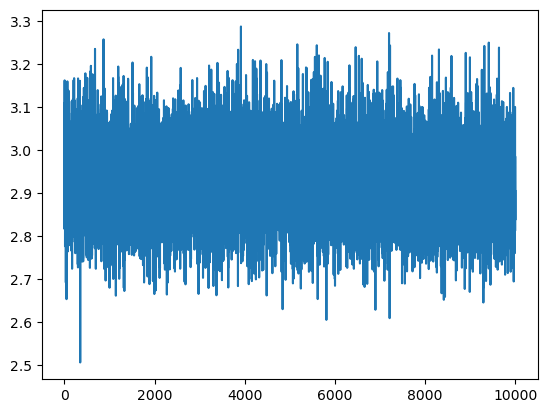

In [191]:
plt.plot(stepi, lossi)

In [198]:
emb = C[Xtrain]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss.item()

2.9189064502716064

In [199]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.921959161758423

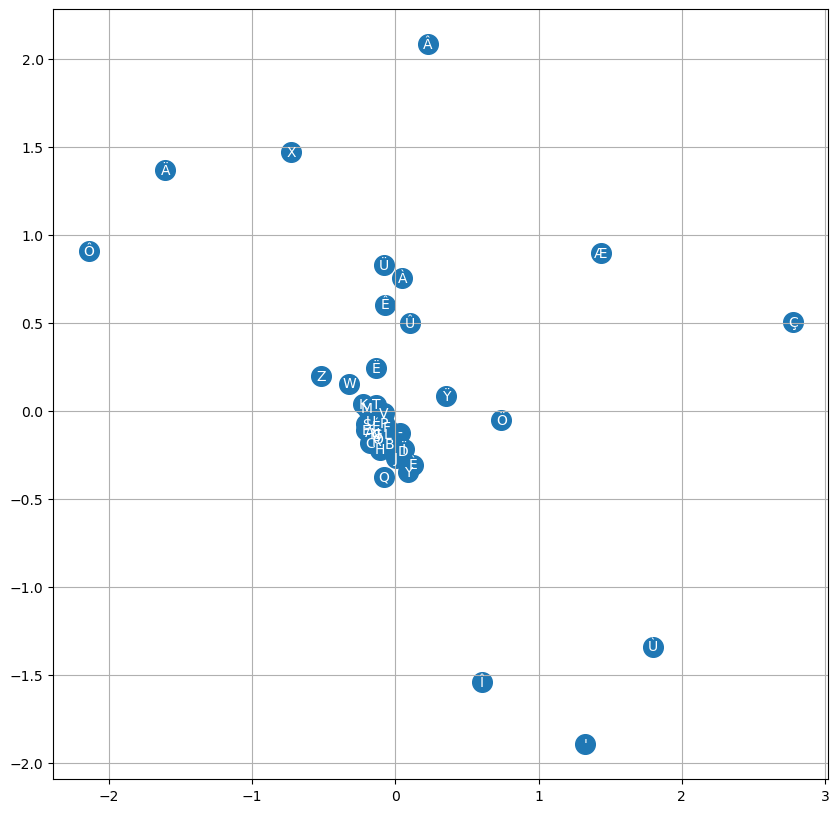

In [200]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')